In [31]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import re

root = Tk()
root.withdraw()

# read data
file_paths1 = filedialog.askopenfilenames(title="Select Training-Data files", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
file_path2 = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# Inclusionリストを取得
Inclusion = []
pattern = re.compile(r'Inclusion_(\d+\.?\d*)%')

for path in file_paths1:
    match = pattern.search(path)
    if match:
        Inclusion.append(match.group(1))

print("Inclusion:", Inclusion)

# 各トレーニングデータファイルに対するデータフレームを格納する辞書
train_dfs = {fp: pd.read_excel(fp) for fp in file_paths1}
test_df = pd.read_excel(file_path2)
df_setting = pd.read_excel(Setting_File_path)

# 設定ファイルから特徴量とターゲット変数を取得
feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]



Inclusion: ['10.5', '30.3', '49.7', '73.2', '79.9', '90.2', '97.2']


In [44]:
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import pickle
import os

final_rmses = []
final_mapes = []

for file_path, train_df in train_dfs.items():
    # 特徴量とターゲット変数の設定
    feature_vars = train_df.columns.drop(target_variable)
    X = train_df[feature_vars].values
    y = train_df[target_variable].values

    # Optunaの目的関数を定義
    def objective(trial):
        # ハイパーパラメータの提案
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        }

        # k-fold CVの設定
        kf = KFold(n_splits=5, shuffle=True, random_state=0)
        rmse_scores = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # モデルの訓練
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)

            # 検証データに対する予測と評価
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_scores.append(rmse)

        # RMSEの平均を返す
        return np.mean(rmse_scores)


    # MAPEを計算する関数を定義
    def calculate_mape(y_true, y_pred, epsilon=1e-8):
        # 分母が0に近い場合は計算から除外
        mask = y_true > epsilon
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]
        
        # MAPEを計算
        mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
        mape = 100 - mape
        return mape

    # ハイパーパラメータチューニングの前に既存のモデルをチェック
    excel_name = os.path.splitext(os.path.basename(file_path))[0]
    pickle_filename = f'best_params_{excel_name}.pkl'
    best_params = None

    # 既にハイパーパラメータのファイルが存在する場合、読み込む
    if os.path.isfile(pickle_filename):
        with open(pickle_filename, 'rb') as f:
            best_params = pickle.load(f)

    # 既存のハイパーパラメータがない場合、ハイパーパラメータチューニングを行う
    if best_params is None:
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=50)
        best_params = study.best_params
        # ハイパーパラメータ保存
        with open(pickle_filename, 'wb') as f:
            pickle.dump(best_params, f)

    # 最適なハイパーパラメータでモデルを訓練
    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y)

    # テストデータを評価
    X_test = test_df[feature_vars].values
    y_test = test_df[target_variable].values
    y_pred_test = best_model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    final_mape = calculate_mape(y_test, y_pred_test)

    # 結果を保存
    final_rmses.append(final_rmse)
    final_mapes.append(final_mape)

print(f"Inclusion:{Inclusion}")
print(f"rmses:{final_rmses}")
print(f"mapes:{final_mapes}")


Inclusion:['10.5', '30.3', '49.7', '73.2', '79.9', '90.2', '97.2']
rmses:[5.286998394959886, 4.627407919554542, 4.237910959865811, 3.080537431533598, 3.1326615728387193, 3.0662907063234837, 2.9105386552371164]
mapes:[95.94675135839155, 96.39475648680062, 96.70794550728777, 97.77824792581237, 97.73506097726778, 97.78016509120653, 97.94456771467861]


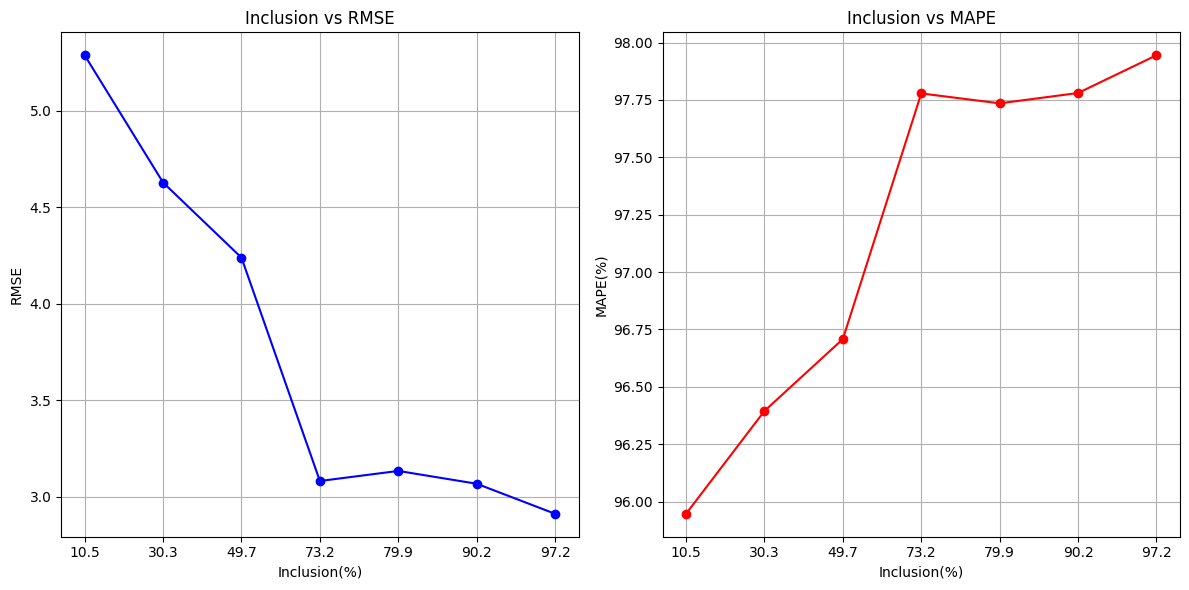

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

# RMSEのグラフ描画
ax1.plot(Inclusion, final_rmses, 'o-', color='blue')
ax1.set_title('Inclusion vs RMSE')
ax1.set_xlabel('Inclusion(%)')
ax1.set_ylabel('RMSE')
ax1.grid(True)

# MAPEのグラフ描画
ax2.plot(Inclusion, final_mapes, 'o-', color='red')
ax2.set_title('Inclusion vs MAPE')
ax2.set_xlabel('Inclusion(%)')
ax2.set_ylabel('MAPE(%)')
ax2.grid(True)

plt.tight_layout()  # グラフ同士の間隔を自動調整
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# プロットの初期化
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_count = 0

# 各Inclusionの値に対するグラフを生成
for file_path, model_info in models.items():
    test_df = test_dfs[file_path]
    best_model = model_info['model']
    
    # テストデータと予測値の取得
    X_test = test_df[feature_vars].values
    y_test = test_df[target_variable].values
    y_pred = best_model.predict(X_test)
    
    # 時系列データの取得
    time_data = test_df['time']  # '時間'は適切な時間列の名前に置き換えてください

    # グラフ描画
    axs[plot_count].plot(time_data, y_test, label='Actual', color='blue', linewidth=2)
    axs[plot_count].plot(time_data, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    axs[plot_count].set_title('Inclusion: ' + str(model_info['inclusion']))
    axs[plot_count].set_xlabel('Time')
    axs[plot_count].set_ylabel('Throttle Opening')
    axs[plot_count].legend()

    plot_count += 1
    if plot_count >= 4:
        break

# グラフを表示
plt.tight_layout()
plt.show()
